## Thin plate spline

Find an interpolating surface to a set of control points with minimum bend. For image interpolation consider two such surfaces, one for each principal axis.

### References
[1] Donato, G., & Belongie, S. J. (2003). Approximation methods for thin plate spline mappings and principal warps. Department of Computer Science and Engineering, University of California, San Diego.

In [6]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [7]:
class TPS:
    def __init__(self):
        self.p = None
        
    def fit(self, c, lambd=0.):        
        n = c.shape[0]        
        U = self._u(self._d(c, c))
        K = U + np.eye(n)*lambd

        P = np.ones((n, 3))
        P[:, 1:] = c[:, :2]

        v = np.zeros(n+3)
        v[:n] = c[:, -1]

        A = np.zeros((n+3, n+3))
        A[:n, :n] = K
        A[:n, -3:] = P
        A[-3:, :n] = P.T

        self.p = np.linalg.solve(A, v) # p has structure w,a
        self.c = np.copy(c)
        
    def __call__(self, x):
        x = np.atleast_2d(x)
        U = self._u(self._d(x, self.c))
        b = np.dot(U, self.p[:-3])
        return self.p[-3] + self.p[-2]*x[:, 0] + self.p[-1]*x[:, 1] + b
        
    def _d(self, a, b):
        return np.sqrt(np.square(a[:, None, :2] - b[None, :, :2]).sum(-1))
    
    def _u(self, r):
        return r**2 * np.log(r + 1e-6)

In [8]:
c = np.array([
    [0., 0, 0.5],
    [0.5, 0.75, 0.4],
    [1., 0, 0.0],
    [1., 1, 0.0],
    [0, 1, 0.0],
])

tps = TPS()
tps.fit(c)

(0, 0.8)

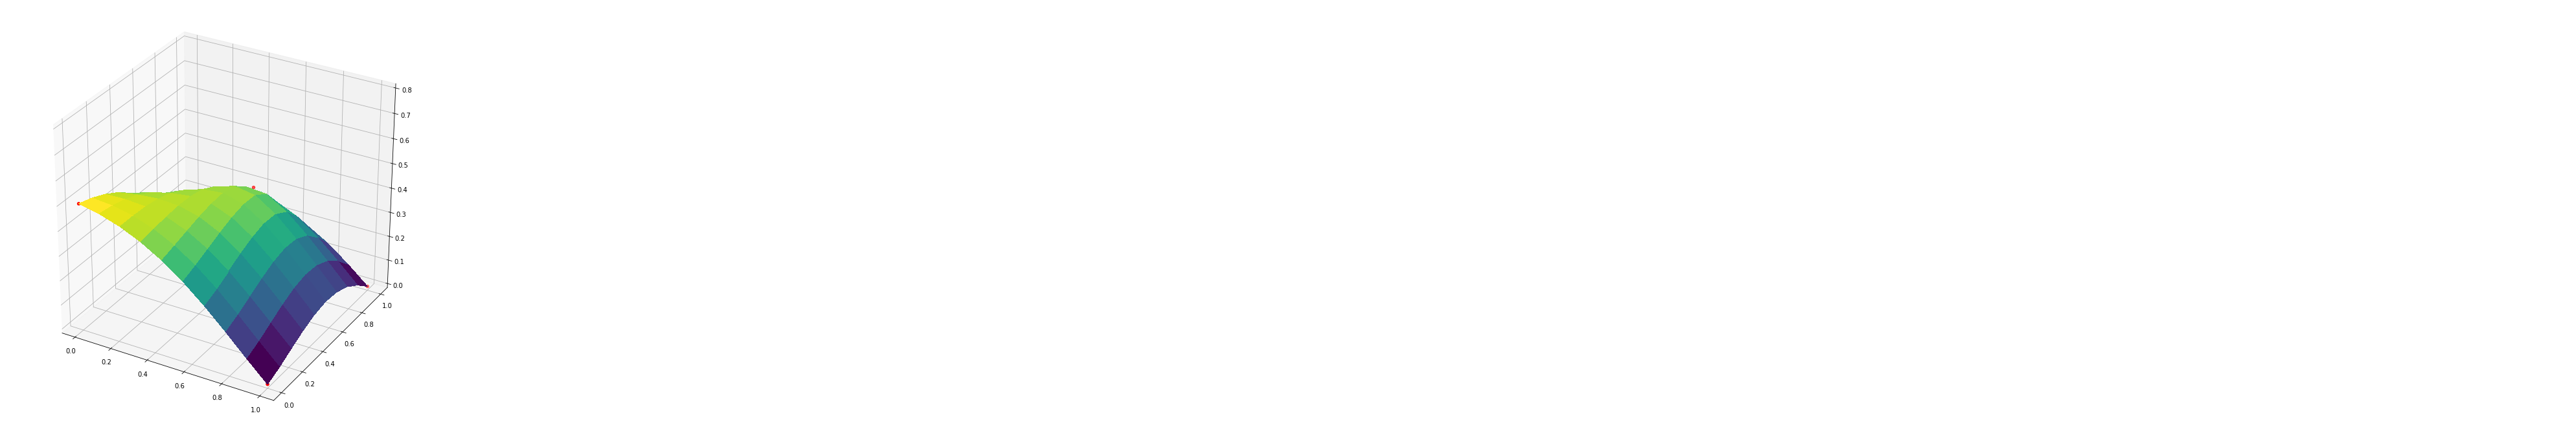

In [11]:
X = np.linspace(0, 1, 10)
Y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(X, Y)
xy = np.hstack((X.reshape(-1, 1),Y.reshape(-1, 1)))
Z = tps(xy).reshape(10, 10)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, linewidth=1, shade=True, antialiased=False, cmap='viridis')
ax.scatter(tps.c[:, 0], tps.c[:, 1], tps.c[:, 2], c='r', zorder=2)
ax.set_zlim(0,0.8)